In [2]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [3]:
import tensorflow as tf

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [17]:
# These import statements worked on my macbook

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Concatenate, Flatten
from keras.regularizers import l1, l2, l1_l2
from keras.initializers import truncated_normal, glorot_normal
from keras.utils.np_utils import to_categorical

from keras.datasets import mnist

In [16]:
# These import statements should work with the McCrea 103 installation of tensorflow and keras

import tensorflow
from tensorflow import keras

from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Concatenate
from tensorflow.python.keras.regularizers import l1, l2, l1_l2
from tensorflow.python.keras.initializers import truncated_normal, glorot_normal
from tensorflow.python.keras.utils.np_utils import to_categorical

from tensorflow.python.keras.datasets import mnist

# Aims of this practical session

* To define and use different deep models using the Keras Models API, which is more general than the Sequential API we have used so far

* To examine the effect of batch normalisation and skip-forward connections on learning with deep networks. 

* To examine the effect of different amounts of regularisation on the same architecture, and to plot a graph of training and validation error as a function of the amount of regularisation

* To explore the MNIST dataset and plot learning curves to estimate error rates as a function of training set size

* To do your own exploration of applying different architectures to the MNIST data (and possibly also to the CIFAR data during the week)

# Keras datasets

Several well known datasets are provided with the Keras implementation, and can be imported and easily used.

The MNIST dataset is a famous and has been used as a testbed of machine learning algorithms for more than 25 years. 

Look at the Keras documentation (at Keras.io ) to find out about other datasets included with Keras.  There is an interesting dataset called fashion_MNIST which is a plug-in replacement for the MNIST dataset, but which may have very different properties (it is grey-scale images). (It is possible that you may need to download this from the web if you want to use it. ) 

In [7]:
type(mnist)

module

In [8]:
# look at the Keras documentation on datasets at 
(x_train,y_train),(x_test, y_test) = mnist.load_data()

In [9]:
x_train.shape, y_train.shape  # both x_train and y_train are numpy arrays

((60000, 28, 28), (60000,))

In [10]:
# we need to reshape the training data to have 4D, since we want each digit to be read as an image
# with only one colour channel

x_train = x_train.reshape([60000,28,28,1])
x_test = x_test.reshape([10000,28,28,1])

x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [11]:
# to use softmax, we need to alter the class representations from integers to 'one-hot' 

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
y_train_one_hot.shape, y_test_one_hot.shape

((60000, 10), (10000, 10))

In [12]:
# let's take a closer look at the one-hot representations

# this code prints the class labels in the left-most column, 
# followed by the one-hot representation. 

# Note that the one-hot representation has a 1 at only one position in 
# each row: the position corresponding to the class index. 
# Only one element is "hot" for each example. 

np.hstack( [y_train[:10].reshape([10,1]), y_train_one_hot[:10,:]] )

array([[5., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [4., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [4., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

Let's look at some of the digits. 

In [13]:
def plot_images(images_to_plot, titles=None, ncols=6, thefigsize=(18,18)):
    
    n_images = images_to_plot.shape[0]
    
    nrows = np.ceil(n_images/ncols).astype(int)
    
    fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
    ax = ax.flatten()

    for i in range(n_images):
        ax[i].imshow( images_to_plot[i,:,:,0], cmap=cm.Greys ) 
            # cmap=cm.Greys plots in Grey scale so the image looks as if it were written
        ax[i].axis('off')  
        if titles is not None:
            ax[i].set_title(titles[i])

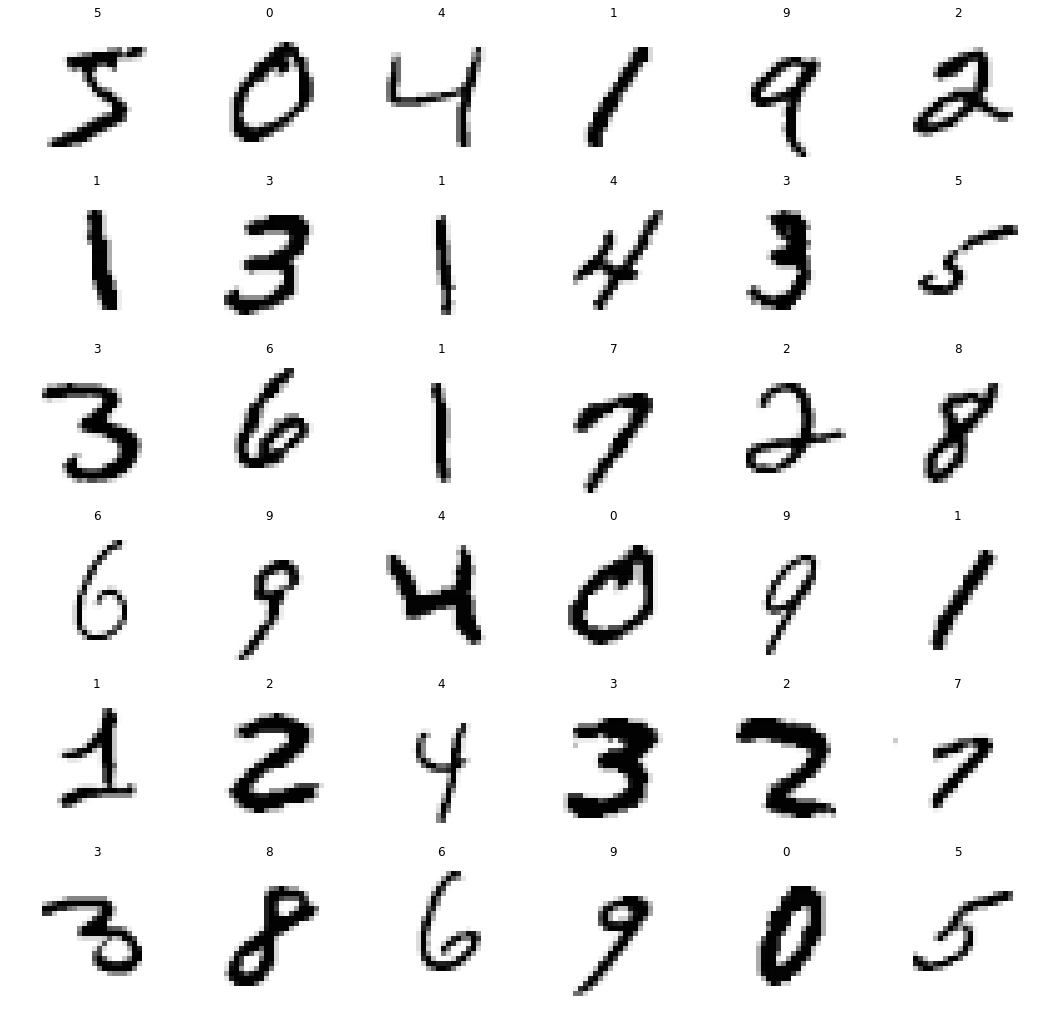

In [14]:
plot_images( x_train[:36,:,:,:], titles= y_train[:36])

Classifying these isn't easy: look how different the 4s are from each other, and the 5s. 

Take a moment to look at the images carefully: what do you think are the difficulties of classifying these with a neural net?  How large are the features that you would need to use? 

# Neural network models for MNIST classification

It is best not to use the entire MNIST dataset as a training set because you will be training for the whole of the practical class. You will learn much more by training repeatedly on smaller subsets, and examining the effect of using different models and parameters. 

In [18]:
# This model is specified using the Keras Sequential API, which allows one to specify a network which is a 
# linear sequence of layers, the output of one being the input of the next
# Please look at the Keras documentation on the API

# we have specified this model in finer detail than last week
# 

model_1=Sequential()
model_1.add(Conv2D(6,(3,3),padding='same',input_shape=(28,28,1)))
model_1.add(Activation('relu'))
model_1.add(Conv2D(6,(3,3),padding='same'))  # A depth of only 6 convolutional filters here: do we need more to keep the information? 
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2,2),strides=None,padding='valid')) 
# you might want to try adding more convolutions and pooling here 
model_1.add(Flatten()) # reshapes the square array of the image into a vector
model_1.add(Dense(100)) # this is a pure linear transform
model_1.add(BatchNormalization())   
model_1.add(Activation('tanh'))     # Activation is a layer that applies a non-linearity to its inputs
model_1.add(Dense(100))
#model_1.add(BatchNormalization())
model_1.add(Activation('tanh'))
model_1.add(Dense(100))
#model_1.add(BatchNormalization()) # we can drop BatchNormalization into or out of the model at will. 
model_1.add(Activation('tanh'))
model_1.add(Dense(100))
model_1.add(BatchNormalization())
model_1.add(Activation('tanh'))
model_1.add(Dense(100))
#model_1.add(BatchNormalization())
model_1.add(Activation('tanh'))
model_1.add(Dense(10))
model_1.add(Activation('softmax'))

In [19]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 6)         60        
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 6)         330       
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 6)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1176)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               117700    
__________

In [20]:
model_1.compile(optimizer='RMSprop',loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
train_size = 4000

In [22]:
np.sum( y_train_one_hot[:train_size,:],axis=0) # this shows that there are reasonable numbers of 

array([379., 444., 397., 392., 430., 350., 405., 433., 373., 397.],
      dtype=float32)

In [23]:
history_1 = model_1.fit( x_train[:train_size,:,:,:],y_train_one_hot[:train_size,:],
                        epochs=20, batch_size=64, shuffle=True,
                       validation_data=(x_test,y_test_one_hot))

Train on 4000 samples, validate on 10000 samples
Epoch 1/20
4000/4000 [==============================] - 3s 665us/step - loss: 0.4942 - acc: 0.8692 - val_loss: 0.3644 - val_acc: 0.8865
Epoch 2/20
4000/4000 [==============================] - 2s 493us/step - loss: 0.1725 - acc: 0.9502 - val_loss: 0.3439 - val_acc: 0.8985
Epoch 3/20
4000/4000 [==============================] - 2s 492us/step - loss: 0.0912 - acc: 0.9748 - val_loss: 0.2826 - val_acc: 0.9147
Epoch 4/20
4000/4000 [==============================] - 2s 491us/step - loss: 0.0568 - acc: 0.9848 - val_loss: 0.2181 - val_acc: 0.9368
Epoch 5/20
4000/4000 [==============================] - 2s 503us/step - loss: 0.0320 - acc: 0.9915 - val_loss: 0.3841 - val_acc: 0.8971
Epoch 6/20
4000/4000 [==============================] - 2s 489us/step - loss: 0.0302 - acc: 0.9908 - val_loss: 0.3058 - val_acc: 0.9241
Epoch 7/20
4000/4000 [==============================] - 2s 476us/step - loss: 0.0216 - acc: 0.9940 - val_loss: 0.1872 - val_acc: 0.9484

There is controversy in the ML community over whether it is better to apply Batch Normalization between a Dense (linear transformation) layer and a non-linearity, or whether it is better to do Batch Normalization after a non-linearity.  You can easily try both with this model - just move the BatchNormalization layers after the Activation layers instead of before. 

The original inventors of batch normalization - Ioffe and Szegedy in 2015 - argued that it made more sense to put Batch Normalization after a Dense layer, because the weighted mixtures produced by the dense layer would distributed more like normal distributions, so that normalization by zeroing the mean and variance would be more naturally to apply. But, since, others have found that Batch Normalization sometimes works better directly after a non-linearity.  
There is no consensus as to which view is better.  Which camp are you in? 

## Examining errors

5% errors on the test set is not good for MNIST, but remember that, for speed, we are using only 1/15th of the training data available. State-of-the-art (SOTA) results are down to less than 1% misclassified (but these are probably overfitted because so many people have studied this dataset and tried too many different methods on it!) 

It can be revealing to examine errors: we need a function to identify errors, and another to plot them. 

In [25]:
predictions = model_1.predict( x_test )

In [26]:
predictions[:3,:]

array([[1.26440909e-07, 3.69005136e-07, 6.61088961e-08, 1.16237807e-07,
        1.53801274e-08, 2.13517353e-07, 4.88551954e-08, 9.99998927e-01,
        8.86078144e-09, 1.08536675e-07],
       [2.74583249e-06, 5.32206730e-04, 9.95586038e-01, 1.51531582e-04,
        8.55051496e-08, 1.96731705e-07, 3.67548689e-03, 4.96924731e-05,
        1.78700975e-06, 1.87933168e-07],
       [1.02968670e-07, 9.99991775e-01, 9.22426636e-07, 3.57807406e-09,
        2.60964816e-06, 4.12442660e-07, 1.46350501e-07, 3.75095033e-06,
        3.53844996e-07, 5.77101611e-09]], dtype=float32)

In [27]:
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes.shape

(10000,)

In [28]:
prediction_errors = np.not_equal( predicted_classes, y_test )

In [29]:
np.sum( prediction_errors)

482

In [30]:
error_images = x_test[ prediction_errors, :, : , :]

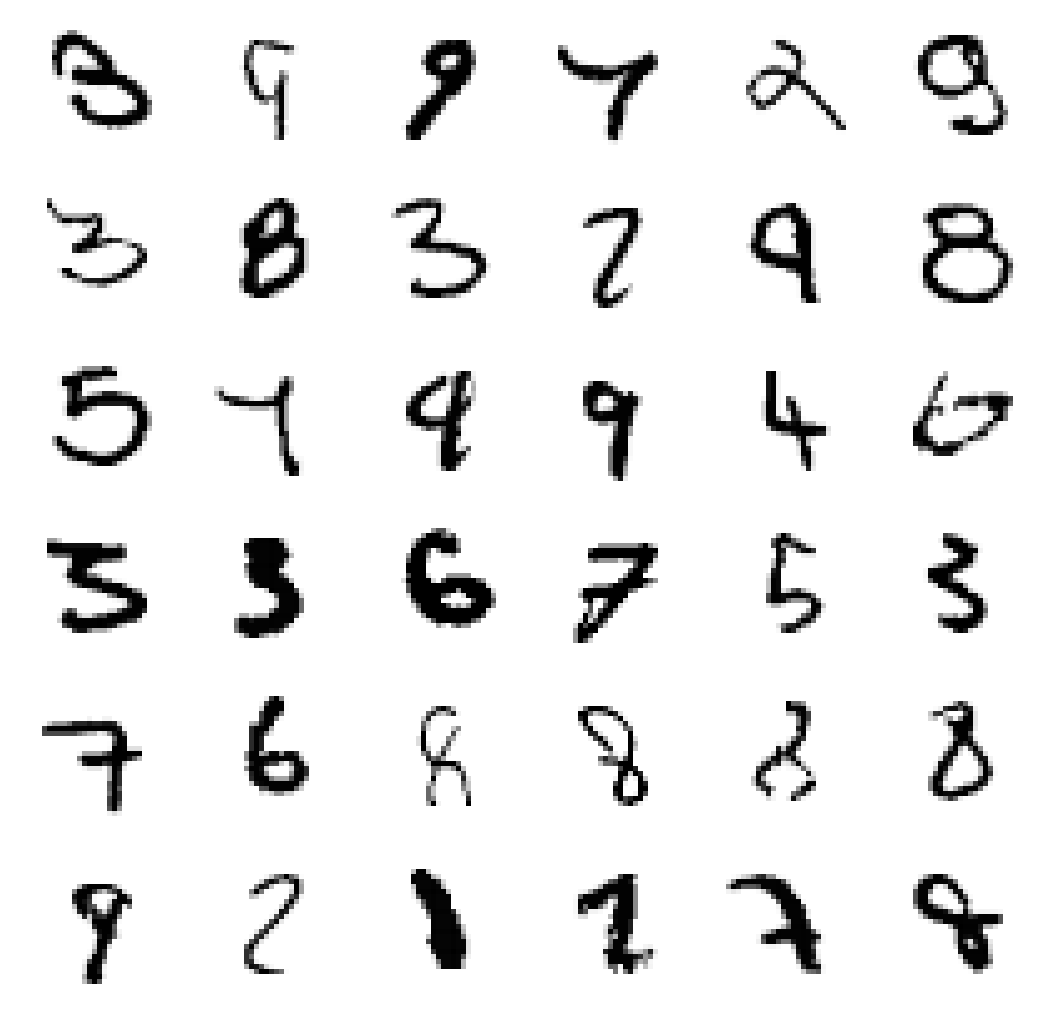

In [31]:
plot_images( error_images[:36,:,:,:], None)

Are these numbers badly drawn?  Are there plausible reasons why they have been misclassified? What are some different reasons?  (There are several different types of reason - this is typical of real problems with large datasets.) 

*Self help*: Modify the `plot_images` statement above to give the images titles with the true classification and the (wrong) predicted classification.

# Using the Keras functional API

Read the introduction to the Keras Functional API at https://keras.io/getting-started/functional-api-guide/
    
The benefit of using the functional API is that we can define models that have layers connected in a (directed acyclic) graph, not just in a linear sequence.  This gives considerably more flexibility in designing models with different architectures.   

In [32]:
# this is the same model as before, 
# but specified using the Keras functional API instead of the Keras Sequential API

inputs = Input(shape=(28,28,1)) # in the functional API, Input is a layer in itself

# to define the next layers, we use the layer itself as a parametrised function, and apply it to the 
# inputs of that layer. We also give each layer a name, for reasons that will become clear
conv1 = Conv2D(6,(3,3),activation='relu',padding='same')(inputs)  
# here I have not separated the activation layers from the Conv2D layers, but you could do so 
conv2 = Conv2D(6,(3,3),activation='relu',padding='same')(conv1)
maxpool = MaxPooling2D(pool_size=(2,2),strides=None,padding='valid')(conv2)
flattened = Flatten()(maxpool)
dense1 = Dense(100,activation='relu')(flattened)

dense2 = Dense(100)(dense1)
bn2 = BatchNormalization()(dense2)
abn2 = Activation('relu')(bn2)
dense3 = Dense(100,activation='relu')(abn2)

dense4 = Dense(100)(dense3)
bn4 = BatchNormalization()(dense4)  
abn4 = Activation('relu')(bn4)
dense5 = Dense(100,activation='relu')(abn4)

outputs = Dense(10,activation='softmax')(dense5)

model_2 = Model(inputs, outputs) # after defining all the layers, we finally define the model
      # by specifying its inputs and outputs
    
    # this model can now be fitted and trained just like a model defined using the Sequential API

In [33]:
# This model uses the possibility of a Merge layer (the Add layers) in the functional API
# to construct skip-forward connections, to produce a resnet

inputs = Input(shape=(28,28,1))
conv1 = Conv2D(6,(3,3),activation='relu',padding='same')(inputs)
conv2 = Conv2D(6,(3,3),activation='relu',padding='same')(conv1)
maxpool = MaxPooling2D(pool_size=(2,2),strides=None,padding='valid')(conv2)
flattened = Flatten()(maxpool)
dense1 = Dense(100,activation='relu')(flattened)

dense2 = Dense(100)(dense1)
bn2 = BatchNormalization()(dense2)
abn2 = Activation('relu')(bn2)
dense3 = Dense(100,activation='relu')(abn2)

merge_1_3 = Add()( [dense3,dense1] ) # this implements a skip-forward connection from dense1 to the output of dense3

dense4 = Dense(100)(dense3)
bn4 = BatchNormalization()(dense4)  
abn4 = Activation('relu')(bn4)
dense5 = Dense(100,activation='relu')(abn4)

merge_3_5 = Add()( [merge_1_3, dense5] )


outputs = Dense(10,activation='softmax')(merge_3_5)

model_2 = Model(inputs, outputs) # after defining all the layers, we finally define the model
      # by specifying its inputs and outputs

The skip-forward connections can be added at various points; another place to add the skip-forwards is between the Batchnormalization layers and the next non-linearity ( as shown in a comment). Be sure to 

In [34]:
model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 28, 28, 6)    60          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 6)    330         conv2d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 14, 14, 6)    0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
flatten_3 

It has been found that resnets (ie networks with skip-forward connections) learn faster, find better optima, and typically generalise better than networks without forward-skip connections. 

Try adding more layers and more skip-forward connections. Compare learning with and without the skip-forward connections. With more layers, do you find that the skip-forward connections make learning faster or slower? Do they improve fit to the training set? 

Is it better to place the merge layers between a BatchNormalization and an Activation layer? 

In [35]:
model_2.compile(optimizer='RMSprop',loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
history_2 = model_2.fit( x_train[:train_size,:,:,:],y_train_one_hot[:train_size,:],
                        epochs=20, batch_size=64, shuffle=True,
                       validation_data=(x_test,y_test_one_hot))

Train on 4000 samples, validate on 10000 samples
Epoch 1/20
4000/4000 [==============================] - 3s 718us/step - loss: 14.3419 - acc: 0.1095 - val_loss: 14.4610 - val_acc: 0.1027
Epoch 2/20
4000/4000 [==============================] - 2s 480us/step - loss: 14.3733 - acc: 0.1082 - val_loss: 14.4607 - val_acc: 0.1027
Epoch 3/20
4000/4000 [==============================] - 2s 482us/step - loss: 14.3733 - acc: 0.1082 - val_loss: 14.4607 - val_acc: 0.1027
Epoch 4/20
4000/4000 [==============================] - 2s 480us/step - loss: 14.3733 - acc: 0.1082 - val_loss: 14.4607 - val_acc: 0.1027
Epoch 5/20
4000/4000 [==============================] - 2s 480us/step - loss: 14.3733 - acc: 0.1082 - val_loss: 14.4607 - val_acc: 0.1027
Epoch 6/20
4000/4000 [==============================] - 2s 480us/step - loss: 14.3733 - acc: 0.1082 - val_loss: 14.4607 - val_acc: 0.1027
Epoch 7/20
4000/4000 [==============================] - 2s 488us/step - loss: 14.3733 - acc: 0.1082 - val_loss: 14.4607 - v

# Other Datasets

Look at the Keras datasets documentation: other datasets you may want to import are CIFAR 10.Importing CIFAR 10 requires a substantial download, so you are advised to do it AFTER this practical class. 

When using CIFAR with just a CPU, your network training will be very slow and you won't get much done in the class, so I advise you to do it during the week.  

In [ ]:
from tensorflow.python.keras.datasets import cifar10
(cx_train, cy_train),(cx_test, cy_test) = cifar10.load_data()

In [37]:
from keras.datasets import cifar10
(cx_train, cy_train),(cx_test, cy_test) = cifar10.load_data()

You will need to alter the plot-images function to plot these as three-layer images, in correct color. 

That is, we need alter the code to plot all 3 layers:

In [38]:
def plot_colour_images(images_to_plot, titles=None, ncols=6, thefigsize=(18,18)):
    
    n_images = images_to_plot.shape[0]
    
    nrows = np.ceil(n_images/ncols).astype(int)
    
    fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
    ax = ax.flatten()

    for i in range(n_images):
        ax[i].imshow( images_to_plot[i,:,:,:] ) 
            # cmap=cm.Greys plots in Grey scale so the image looks as if it were written
        ax[i].axis('off')  
        if titles is not None:
            ax[i].set_title(titles[i])

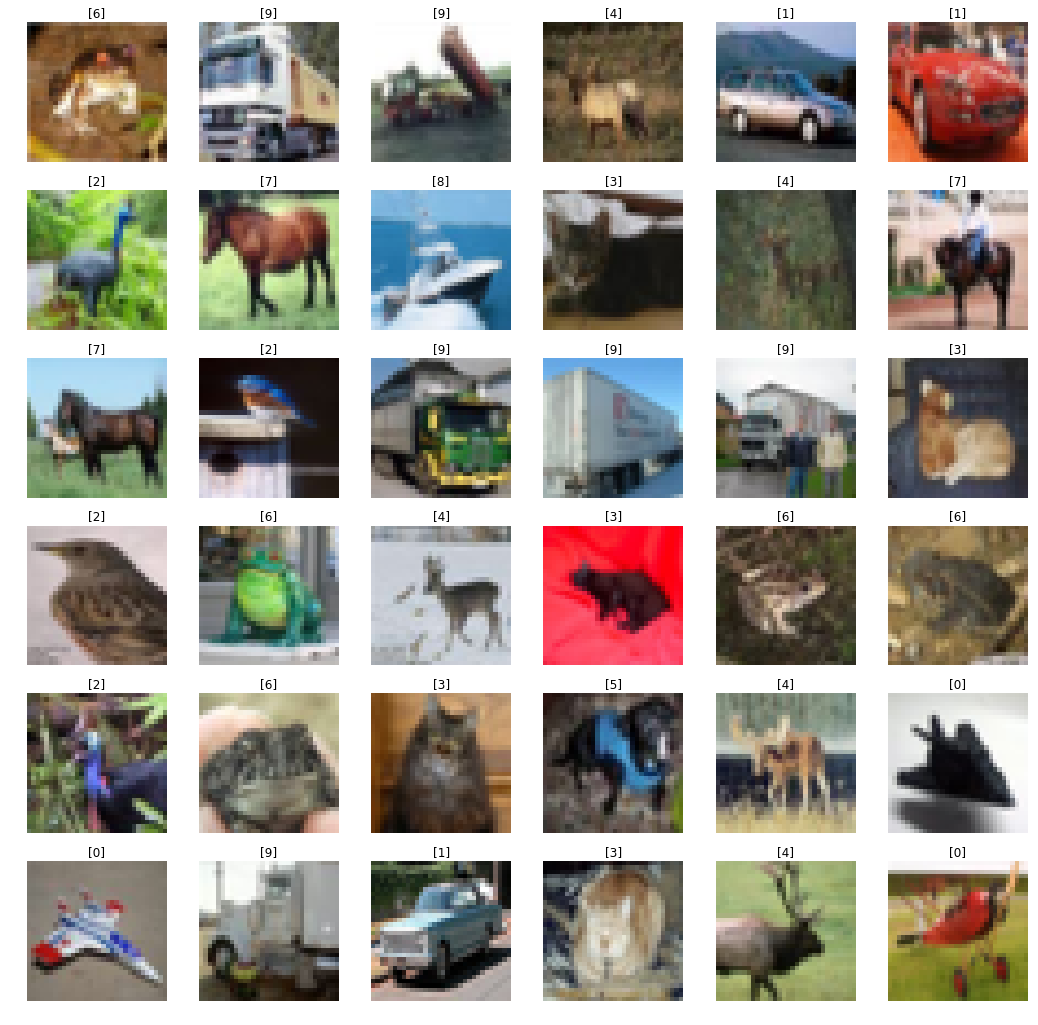

In [39]:
plot_colour_images( cx_train[:36,:,:], titles= cy_train[:36])

You should look at the CIFAR 10 documentation at https://www.cs.toronto.edu/~kriz/cifar.html to find out what the classes are: can you guess the 10 classes by looking at the pictures without reading the documentation? 